In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
#given inputs
temp = 298 #kelvin
pres = 1e5 #Pascals
Rgas = 8.314 #J/(mol-K)
avo = 6.022e23 
PHOx = 0.1 #pptv/s

#rate constants, units are cm3/(molec-s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015 # units s-1
k8 = 1.9e-14

#unit conversions
airden = (pres*avo) / (Rgas*temp*1e6) #molec/cm3
CPHOx = PHOx*1e-12*airden  #molec/(cm3-s)
ppbfac = 1e9/airden
t0 = 0
tmax = 96*3600

In [3]:
# u[0] u[1] u[2] u[3] u[4] u[5] u[6]
# NO   NO2   OH  RO2  HO2   O3   RH
def mixing_ratio(t,u):
    f = np.zeros(7)
    f[0] = -k2*u[3]*u[0] + k7*u[1] - k8*u[5]*u[0] - k3*u[4]*u[0]
    f[1] = k2*u[3]*u[0] + k3*u[4]*u[0] + k8*u[5]*u[0] - k7*u[1] - k4*u[2]*u[1]
    f[2] = -k1*u[6]*u[2] + k3*u[4]*u[0] - k4*u[2]*u[1] + CPHOx 
    f[3] = k1*u[6]*u[2] - k2*u[3]*u[0] - k6*u[3]*u[4]
    f[4] = k2*u[3]*u[0] - k3*u[4]*u[0] - 2*k5*u[4]**2 - k6*u[3]*u[4]
    f[5] = k7*u[1] - k8*u[5]*u[0]
    f[6] = -k1*u[6]*u[2]
    return f

In [4]:
def max_o3 (nox, rh): 
    Cnox = nox*1e-9*airden
    Crh = rh*1e-9*airden
    #initial conditions
    # NOx = NO + NO2
    u0 = np.zeros(7)
    u0[0] = Cnox*(2/3)
    u0[1] = Cnox*(1/3)
    u0[2] = 0
    u0[3] = 0
    u0[4] = 0
    u0[5] = 0
    u0[6] = Crh   #molec / cm3 of RH hydrocarbon

    sol = solve_ivp(mixing_ratio, [t0, tmax], u0, method='LSODA', dense_output=True)
    return np.max(sol.y[5]) * ppbfac 

In [ ]:
input_nox = np.arange(0,50,1)
input_rh = np.arange(50,500,9)
sol_max = np.zeros((50,50))

for i, nox in enumerate(input_nox):
    for j, rh in enumerate(input_rh):
        sol_max[i, j] = max_o3(nox, rh)
sol_max

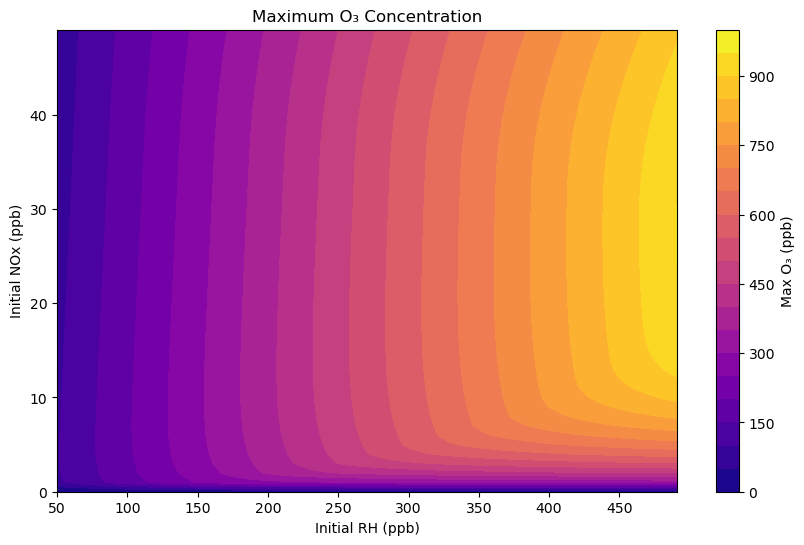

In [18]:
plt.figure(figsize=(10, 6))
cp = plt.contourf(input_rh, input_nox, sol_max, cmap="plasma", levels=20)
plt.colorbar(cp, label="Max O₃ (ppb)")
plt.xlabel("Initial RH (ppb)") 
plt.ylabel("Initial NOx (ppb)")
plt.title("Maximum O₃ Concentration")
plt.show()